In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch

import numpy as np

import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms, datasets
import torch.backends.cudnn as cudnn
from torch.autograd import Function
import torchvision.transforms as T
from torch.autograd import Variable
import torch.optim as optim

# Data

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def show_img(source, target, source_label, target_label):
    num_row = 4
    num_col = 5
    num = 10
    images = source[:num]
    labels = source_label[:num]

    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        
        image =  images[i].transpose(0,2).transpose(0,1)

        ax.imshow(image, cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))


    images = target[:num]
    labels = target_label[:num]
    for i in range(10,20):
        ax = axes[i//num_col, i%num_col]
        image = images[i - 10].transpose(0,2).transpose(0,1)
        ax.imshow(image, cmap='gray')
        ax.set_title('Label: {}'.format(labels[i - 10]))
    plt.tight_layout()
    plt.show()

In [4]:
def get_backgrounds():
    backgrounds = []
    for file in os.listdir("./images/train"):
        if file.endswith('.jpg'):
            backgrounds.append(plt.imread(os.path.join("./images/train",file)))
    return np.array(backgrounds)
backgrounds = get_backgrounds()


def compose_image(image):
    image = (image > 0).astype(np.float32)
    image = image.reshape([28,28])*255.0
    
    image = np.stack([image,image,image],axis=2)
    
    background = np.random.choice(backgrounds)
    w,h,_ = background.shape
    dw, dh,_ = image.shape
    x = np.random.randint(0,w-dw)
    y = np.random.randint(0,h-dh)
    
    temp = background[x:x+dw, y:y+dh]
    return np.abs(temp-image).astype(np.uint8)


class MNISTM(Dataset):
            
    def __init__(self, train=True,transform=None):
        if train:
            self.data = datasets.MNIST(root='.data/mnist',train=True, download=True)
        else:
            self.data = datasets.MNIST(root='.data/mnist',train=False, download=True)
        self.backgrounds = get_backgrounds()
        self.transform = transform
    def __getitem__(self,index):
        image = np.array(self.data.__getitem__(index)[0])
        target = self.data.__getitem__(index)[1]
        image = compose_image(image)
        #image = Image.fromarray(image.squeeze(), mode="RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image, target
        
    def __len__(self):
        return len(self.data)
    
    
def get_mnistm_loaders(data_aug = False, batch_size=128,test_batch_size=1000):
    if data_aug:
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(64),
            transforms.RandomCrop(64,padding=4),
            transforms.ToTensor()
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(64),
            transforms.ToTensor()
        ])
    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(64),
        transforms.ToTensor()
    ])
    kwargs = {}
    train_loader = DataLoader(
        MNISTM(train=True,transform=train_transform),batch_size=batch_size, shuffle=True, drop_last=True)
    train_eval_loader = DataLoader(
        MNISTM(train=True, transform=test_transform),batch_size=test_batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(
        MNISTM(train=False,transform=test_transform),batch_size=test_batch_size, shuffle=False, drop_last=True)
    return train_loader, train_eval_loader, test_loader


def get_mnist_loaders(data_aug = False, batch_size=128,test_batch_size=1000):
    if data_aug:
        train_transform = transforms.Compose(
            [transforms.Resize(64),
            transforms.RandomCrop(64,padding=4),
            transforms.Grayscale(3),
            transforms.ToTensor()
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize(64),
            transforms.Grayscale(3),
            transforms.ToTensor()
        ])
    test_transform = transforms.Compose([
        transforms.Resize(64),
        transforms.Grayscale(3),
        transforms.ToTensor()
    ])
    kwargs = {}

    train_loader = DataLoader(
        datasets.MNIST(root='.data/mnist',train=True, download=True,transform=train_transform),batch_size=batch_size, shuffle=True, drop_last=True)
    train_eval_loader = DataLoader(
        datasets.MNIST(root='.data/mnist',train=True, download=True, transform=test_transform),batch_size=test_batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(
        datasets.MNIST(root='.data/mnist',train=False, download=True, transform=test_transform),batch_size=test_batch_size, shuffle=False, drop_last=True)
    return train_loader, train_eval_loader, test_loader

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [5]:
loader_source, mnist_eval_loader, mnist_test_loader = get_mnist_loaders(batch_size=128)
loader_target, mnistm_eval_loader, mnistm_test_loader = get_mnistm_loaders(batch_size=128)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to .data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to .data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [6]:
source_iter = iter(loader_source)
source_inputs, source_label = source_iter.next()

target_iter = iter(loader_target)
target_inputs, target_label = target_iter.next()

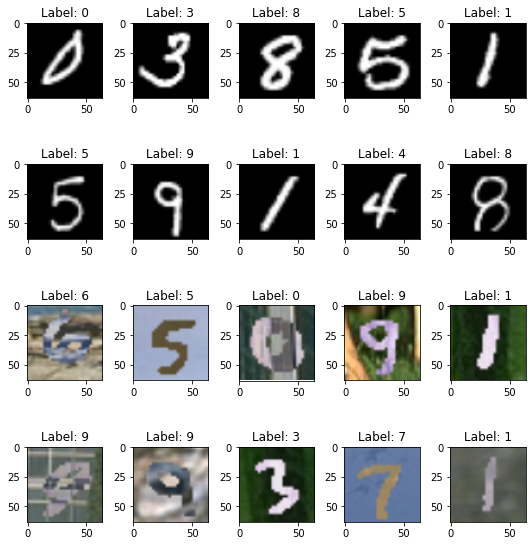

In [7]:
show_img(source_inputs, target_inputs, source_label, target_label)

# S3-Gan

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_nc=3):
        super(Encoder, self).__init__()

        # Initial convolution block
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        model += [nn.Conv2d(64, 128, 3, stride=2, padding=1),
                  nn.InstanceNorm2d(128),
                  nn.ReLU(inplace=True)]
                  
        model += [nn.Conv2d(128, 256, 3, stride=2, padding=1),
                  nn.InstanceNorm2d(256),
                  nn.ReLU(inplace=True)]

        model += [nn.Conv2d(256, 256, 3, stride=2, padding=1),
                  nn.InstanceNorm2d(256),
                  nn.ReLU(inplace=True)]

        model += [nn.Conv2d(256, 512, 3, stride=2, padding=1),
                  nn.InstanceNorm2d(512),
                  nn.ReLU(inplace=True)]

        model += [nn.Conv2d(512, 1024, 3, stride=2, padding=1),
                  nn.InstanceNorm2d(1024),
                  nn.ReLU(inplace=True)]



        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, input_nc=1024, output_nc=3):
        super(Decoder, self).__init__()
        model = [nn.ConvTranspose2d(input_nc, 512, 3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(512),
                  nn.ReLU(inplace=True)]

        model += [nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(256),
                  nn.ReLU(inplace=True)]
        
        model += [nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(128),
                  nn.ReLU(inplace=True)]

        model += [nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(64),
                  nn.ReLU(inplace=True)]

        model += [nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(64),
                  nn.ReLU(inplace=True)]
                  
        
        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.InstanceNorm2d(3),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Identity_Generator(nn.Module):
    def __init__(self, encoder, decoder):
        super(Identity_Generator, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, A, B):
        latentA = self.encoder(A)
        latentB = self.encoder(B)

        reconstructedA = self.decoder(latentA)
        reconstructedB = self.decoder(latentB)
        return reconstructedA, reconstructedB

class Perceptual(nn.Module):
    def __init__(self, encoder, decoder, generator):
        super(Perceptual, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.generator = generator

    def forward(self, A, B):

        reconstructedA, reconstructedB = self.generator(A, B)

        latentA = self.encoder(A)
        latentB = self.encoder(B)

        latentA.detach()
        latentB.detach()

        style = latentA[:, 0:512, : , :]
        content = latentB[:, 512:1024, :, :]
        
        mixed_latent = torch.cat([style, content], dim=1)
        mixed_image = self.decoder(mixed_latent)

        return mixed_image, reconstructedA, reconstructedB

class Discriminator(nn.Module):
    def __init__(self, input_nc = 3):
        super(Discriminator, self).__init__()

        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(512, 1, 4, padding=1)]


        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)


# Load S3gan

In [9]:
perceptual = torch.load("./model_weight/perceptual")

# Generate new dataset

In [10]:
def generate_mixed_image(perceptual, source, target, use_cuda):
    mixed = []
    label = []

    data_target_iter = iter(target)
    for _, (source_inputs, source_label) in enumerate(source):
        batch_size = source_inputs.size(0)
        target_inputs, target_label = data_target_iter.next()

        if use_cuda: 
            source_inputs, target_inputs = source_inputs.cuda(), target_inputs.cuda()

        mixed_image, _, _ = perceptual(source_inputs, target_inputs)
      
        label.extend(target_label.detach().cpu().numpy())
        mixed.extend(mixed_image.detach().cpu().numpy())

    
    return mixed, label

In [11]:
def generate_recon_image(perceptual, source, target, use_cuda):
    label = []
    reconstructed_A = []

    data_target_iter = iter(target)
    for _, (source_inputs, source_label) in enumerate(source):
        batch_size = source_inputs.size(0)
        target_inputs, target_label = data_target_iter.next()

        if use_cuda: 
          source_inputs, target_inputs = source_inputs.cuda(), target_inputs.cuda()

        _, reconstructed_source, _ = perceptual(source_inputs, target_inputs)
      
        label.extend(source_label.detach().cpu().numpy())
        reconstructed_A.extend(reconstructed_source.detach().cpu().numpy())

    return reconstructed_A, label

In [12]:
train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(28),
            transforms.ToTensor()
        ])

class CustomTensorDataset(Dataset):
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [13]:

mixed, label = generate_mixed_image(perceptual, loader_target, loader_source, True)
tensor_mixed = torch.Tensor(mixed)
tensor_label = torch.Tensor(label)

mixed_dataset = CustomTensorDataset([tensor_mixed, tensor_label], train_transform)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:

reconstructionA, label = generate_recon_image(perceptual, loader_target, loader_source, True)
tensor_reconstructionA = torch.Tensor(reconstructionA)
tensor_label = torch.Tensor(label)

recon_dataset = CustomTensorDataset([tensor_reconstructionA, tensor_label], train_transform)

In [15]:
mixed_dataloader = DataLoader(mixed_dataset, batch_size= 128, shuffle=True, drop_last=True)

In [16]:
recon_dataloader = DataLoader(mixed_dataset, batch_size= 128, shuffle=True, drop_last=True)

In [17]:
mixed_iter = iter(mixed_dataloader)
mixed_inputs, mixed_label = mixed_iter.next()

recon_iter = iter(recon_dataloader)
recon_inputs, recon_label = recon_iter.next()

In [18]:
torch.min(mixed_inputs[0][0])

tensor(0.2314)

In [19]:
torch.max(mixed_inputs[0][0])

tensor(0.7608)

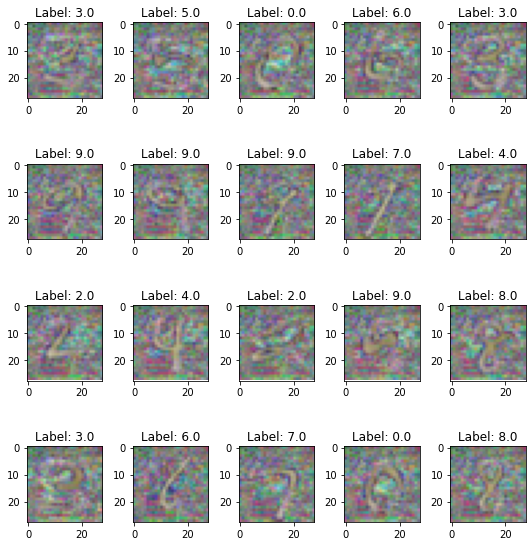

In [20]:
show_img(mixed_inputs, recon_inputs, mixed_label, recon_label)

# DANN

In [21]:
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN(nn.Module):
    def __init__(self):
        super(DANN, self).__init__()
        self.feature = nn.Sequential(
                    nn.Conv2d(3, 64, kernel_size=5),
                    nn.BatchNorm2d(64),
                    nn.MaxPool2d(2),
                    nn.ReLU(True),
                    nn.Conv2d(64, 50, kernel_size=5),
                    nn.BatchNorm2d(50),
                    nn.Dropout2d(),
                    nn.MaxPool2d(2),
                    nn.ReLU(True)
                )
                
        self.avgpool=nn.AdaptiveAvgPool2d((5,5))
        self.classifier = nn.Sequential(
                    nn.Linear(50 * 4 * 4, 100),
                    nn.BatchNorm1d(100),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(100, 100),
                    nn.BatchNorm1d(100),
                    nn.ReLU(True),
                    nn.Linear(100, 10),
                )


        self.domain_classifier = nn.Sequential(
                    nn.Linear(50 * 4 * 4, 100),
                    nn.BatchNorm1d(100),
                    nn.ReLU(True),
                    nn.Linear(100, 2),
                )
    def forward(self, input_data, alpha):
        input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
        feature = self.feature(input_data)
        feature = feature.view(-1, 50 * 4 * 4)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)

        return class_output, domain_output

# Training

In [22]:
epoches = 201

In [23]:
def train(source, target, net, criterion, optimizer, epoch, use_cuda=True):
    net.train() # Sets the module in training mode.

    correct_source_label = 0
    correct_source_domain = 0
    correct_target_label = 0
    correct_target_domain = 0
    total = 0
    batch_size = 128

    data_target_iter = iter(target)
    len_dataloader = min(len(source), len(target))

    for batch_idx, (inputs, source_label) in enumerate(source):

        p = float(batch_idx + epoch * len_dataloader) / (epoches * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.01/(1.+10*p)**0.75

        batch_size = inputs.size(0)
        total += batch_size

        # Feed source image to the network
        source_label = source_label.type(torch.LongTensor)
        domain_label = torch.zeros(batch_size).long()

        if use_cuda:
            inputs, source_label, domain_label = inputs.cuda(), source_label.cuda(), domain_label.cuda()
            
        optimizer.zero_grad()
        inputs, source_label = Variable(inputs), Variable(source_label)
        
        class_output, domain_output = net(inputs, alpha)
        
        _, predicted = torch.max(class_output.data, 1)
        correct_source_label += predicted.eq(source_label.data).cpu().sum().item()
        _, predicted = torch.max(domain_output.data, 1)
        correct_source_domain += predicted.eq(domain_label.data).cpu().sum().item()

        loss_s_label = criterion(class_output, source_label)
        loss_s_domain = criterion(domain_output, domain_label)

        # Feed target image to the network
        target_inputs, target_label = data_target_iter.next()
        domain_label = torch.ones(batch_size).long()
        if use_cuda:
            target_inputs, target_label, domain_label = target_inputs.cuda(), target_label.cuda(), domain_label.cuda()
        
        class_output, domain_output = net(target_inputs, alpha)
        loss_t_domain = criterion(domain_output, domain_label)

        _, predicted = torch.max(class_output.data, 1)
        correct_target_label += predicted.eq(target_label.data).cpu().sum().item()
        _, predicted = torch.max(domain_output.data, 1)
        correct_target_domain += predicted.eq(domain_label.data).cpu().sum().item()

        loss = loss_s_label
        loss.backward()
        optimizer.step()
    
    return correct_source_label, correct_source_domain, correct_target_label, correct_target_domain, total

In [24]:
def get_mnistm_loaders_v2(data_aug = False, batch_size=128,test_batch_size=1000):
    if data_aug:
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(28),
            transforms.RandomCrop(28,padding=4),
            transforms.ToTensor()
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(28),
            transforms.ToTensor()
        ])
    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(28),
        transforms.ToTensor()
    ])
    kwargs = {}
    train_loader = DataLoader(
        MNISTM(train=True,transform=train_transform),batch_size=batch_size, shuffle=True, drop_last=True)
    train_eval_loader = DataLoader(
        MNISTM(train=True, transform=test_transform),batch_size=test_batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(
        MNISTM(train=False,transform=test_transform),batch_size=test_batch_size, shuffle=False, drop_last=True)
    return train_loader, train_eval_loader, test_loader

In [25]:
loader_target, mnistm_eval_loader, mnistm_test_loader = get_mnistm_loaders_v2(batch_size=128)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [26]:
criterion = nn.CrossEntropyLoss()

dann = DANN()
if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    dann.cuda()
    criterion = criterion.cuda()
    
optimizer = optim.Adam(dann.parameters(), lr=0.001) 

history_DANN = []
for epoch in range(0, epoches):
    sl, sd, tl, td, total = train(mixed_dataloader, loader_target, dann, criterion, optimizer, epoch) 
    history_DANN.append([sl/total, sd/total, tl/total, td/total])
    if (epoch % 20 == 0):
        print("e: %d, sl: %f, sd: %f, tl: %f, td: %f" % (epoch, sl/total, sd/total, tl/total, td/total))

e: 0, sl: 0.869157, sd: 0.482839, tl: 0.264640, td: 0.521668
e: 20, sl: 0.985460, sd: 0.480753, tl: 0.279698, td: 0.510834
e: 40, sl: 0.991536, sd: 0.478983, tl: 0.274606, td: 0.599392
e: 60, sl: 0.994474, sd: 0.480652, tl: 0.262987, td: 0.525307
e: 80, sl: 0.995760, sd: 0.478232, tl: 0.262704, td: 0.512887
e: 100, sl: 0.996544, sd: 0.480753, tl: 0.252170, td: 0.538495
e: 120, sl: 0.996945, sd: 0.479751, tl: 0.276810, td: 0.570296
e: 140, sl: 0.997179, sd: 0.480519, tl: 0.272553, td: 0.587674
e: 160, sl: 0.997446, sd: 0.478883, tl: 0.269298, td: 0.542384
e: 180, sl: 0.997947, sd: 0.476095, tl: 0.261101, td: 0.455028
e: 200, sl: 0.998264, sd: 0.478849, tl: 0.259515, td: 0.601629


In [27]:
torch.save(dann, "./model_weight/dann")

# Proxy A-distance

In [28]:
from sklearn import svm

In [29]:
def Proxy_A_distance(features, labels, epochs):
    total_proxy = 0
    for i in range(epochs):
        index = np.random.randint(0,110000,20000)
        x_train = features[index[:10000]]
        y_train = labels[index[:10000]]
        x_test = features[index[10000:]]
        y_test = labels[index[10000:]]
        clf = svm.SVC()
        clf.fit(x_train,y_train)
        predicted = clf.predict(x_test)
        err = np.mean(np.abs(predicted-y_test))
        proxy = 2*(1-2*err)
        total_proxy += proxy
    return total_proxy/epochs

In [30]:
def generate_domain_datas_from_dann(dann, mnist_gen, mnistm_gen):
    with torch.no_grad():
        total_x = torch.tensor([])
        total_y = torch.tensor([])
        for batch_idx, (source, target) in enumerate(zip(mnist_gen, mnistm_gen)):
            source_image, source_label = source
            target_image, target_label = target

            # the source is 1 * 28 * 28, we have to preprocess it
            #source_image = torch.cat((source_image, source_image, source_image),1)

            domain_label = torch.cat((torch.zeros(source_label.size()[0]).type(torch.LongTensor),
                                        torch.ones(target_label.size()[0]).type(torch.LongTensor)),0)
            source = source_image.expand(source_image.data.shape[0],3,28,28)
            source = dann.feature(source.to(device))
            source = source.view(-1,50*4*4).cpu()
            target = target_image.expand(target_image.data.shape[0],3,28,28)
            target = dann.feature(target.to(device))
            target = target.view(-1,50*4*4).cpu()
            temp = torch.cat((source,target),0)
            total_x = torch.cat((total_x,temp),0)
            total_y = torch.cat((total_y,domain_label),0)
    return total_x, total_y

In [31]:
total_x, total_y = generate_domain_datas_from_dann(dann, mixed_dataloader, loader_target)

In [32]:
proxy = Proxy_A_distance(np.array(total_x),np.array(total_y),10)

In [33]:
print(proxy)

1.9905199999921024


# Test on test set

In [34]:
def test(target, net, with_encoder = False, use_cuda = True):
    total = 0
    correct_target_label = 0

    len_dataloader = len(target)

    for batch_idx, (target_inputs, target_label) in enumerate(target):
        batch_size = target_inputs.size(0)
        total += batch_size

        p = float(batch_idx + 200 * len_dataloader) / (200 * len_dataloader)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        if use_cuda: 
            target_inputs, target_label = target_inputs.cuda(), target_label.cuda()

        target_inputs, target_label = Variable(target_inputs), Variable(target_label)
        
        if (with_encoder == False):
            class_output, _ = net(input_data=target_inputs, alpha=alpha)
        else:
            class_output, _, _ = net(input_data=target_inputs, alpha=alpha)

        _, predicted = torch.max(class_output.data, 1)
        correct_target_label += predicted.eq(target_label.data).cpu().sum().item()


    return correct_target_label/total

In [35]:
Dann_test_acc = test(mnistm_test_loader, dann, False, True)

In [36]:
Dann_test_acc

0.2709

# Umap

In [46]:
import seaborn as sns
import umap

In [38]:
def visualize_domain_UMAP(domain_features, domain_labels,name="DAuto-sim",size=None):
    sns.set_style('white')
    if size is not None:
        perm = torch.randperm(domain_features.size(0))
        idx = perm[:size]
        domain_features = domain_features.cpu()[idx]
        domain_labels = domain_labels.cpu()[idx]
    else:
        domain_features = domain_features.cpu()
        domain_labels = domain_labels.cpu()
    reducer = umap.UMAP(
                    n_components=2,
                    random_state=2022,
                    verbose=False)
    #tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
    umap_embedding = reducer.fit_transform(domain_features.cpu().detach().numpy())
    sns.scatterplot(x=umap_embedding[:,0],y=umap_embedding[:,1],hue=domain_labels.cpu().detach().numpy())
    plt.title(name)
    plt.savefig("./plots/"+name+".png")
    plt.show()

In [40]:
def generate_domain_datas_from_dann(dann, mnist_gen, mnistm_gen):
    with torch.no_grad():
        total_x = torch.tensor([])
        total_y = torch.tensor([])
        for batch_idx, (source, target) in enumerate(zip(mnist_gen, mnistm_gen)):
            source_image, source_label = source
            target_image, target_label = target

            # the source is 1 * 28 * 28, we have to preprocess it
            #source_image = torch.cat((source_image, source_image, source_image),1)

            domain_label = torch.cat((torch.zeros(source_label.size()[0]).type(torch.LongTensor),
                                        torch.ones(target_label.size()[0]).type(torch.LongTensor)),0)
            source = source_image.expand(source_image.data.shape[0],3,28,28)
            source = dann.feature(source.to(device))
            source = source.view(-1,50*4*4).cpu()
            target = target_image.expand(target_image.data.shape[0],3,28,28)
            target = dann.feature(target.to(device))
            target = target.view(-1,50*4*4).cpu()
            temp = torch.cat((source,target),0)
            total_x = torch.cat((total_x,temp),0)
            total_y = torch.cat((total_y,domain_label),0)
    return total_x, total_y

In [43]:
total_x, total_y = generate_domain_datas_from_dann(dann, mixed_dataloader, loader_target)

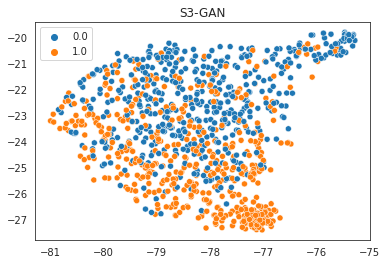

In [49]:
visualize_domain_UMAP(total_x, total_y, name="S3-GAN", size=1000)